# Embedding Model

In [ ]:
#Dependencies
import pandas as pd
import numpy as np
import itertools

# Suppress TensorFlow warnings and info logs
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Import TensorFlow library
import tensorflow as tf

# Libraries for visualization
import matplotlib.pyplot as plt
import plotly.express as px

# Libraries for timing and progress bars
import time
import tqdm

# Download and unzip dataset
!unzip "/content/ml-1m.zip" -d "/content"

# Define root directory and data directory paths
ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, 'ml-1m/')

# Define state size for recurrent model (hyperparameter)
STATE_SIZE = 10

Archive:  /content/ml-1m.zip
replace /content/ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
#Loading datasets

# Read the ratings data from the 'ratings.dat' file
ratings_list = [i.strip().split("::") for i in open(os.path.join(DATA_DIR,'ratings.dat'), 'r').readlines()]

# Read the users data from the 'users.dat' file
users_list = [i.strip().split("::") for i in open(os.path.join(DATA_DIR,'users.dat'), 'r').readlines()]

# Read the movies data from the 'movies.dat' file, handling potential encoding issues
movies_list = [i.strip().split("::") for i in open(os.path.join(DATA_DIR,'movies.dat'),encoding='latin-1').readlines()]

# Convert the lists to NumPy arrays
ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = np.float32)
movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)

# Create a pandas DataFrame for the users data, specifying column names
users_df = pd.DataFrame(users_list, columns=['UserID','Gender','Age','Occupation','Zip-code'])

In [ ]:
# Convert movie id to movie title
movies_id_to_movies = {movie[0]: movie[1:] for movie in movies_list}

In [ ]:
len(movies_list)

3883

In [ ]:
movies_df.head(5)

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings_df.head(5)

,UserID,MovieID,Rating,Timestamp
0,1.0,1193.0,5.0,978300736.0
1,1.0,661.0,3.0,978302080.0
2,1.0,914.0,3.0,978301952.0
3,1.0,3408.0,4.0,978300288.0
4,1.0,2355.0,5.0,978824320.0


In [ ]:
genres = ['Action',
        'Adventure',
        'Animation',
        "Children's",
        'Comedy',
        'Crime',
        'Documentary',
        'Drama',
        'Fantasy',
        'Film-Noir',
        'Horror',
        'Musical',
        'Mystery',
        'Romance',
        'Sci-Fi',
        'Thriller',
        'War',
        'Western']

Let's create embeddings of movies, genres, and users using the correlation between movies and genres and the correlation between movies and users.

First learn the embedding of the movie-genre, and then learn the embedding of the movie-user using the learned movie embedding.

## Creating movie, genre, and user dataframes

In [ ]:
# Create movie id and genres dataframe
movies_genres_df = movies_df[['MovieID', 'Genres']]

In [ ]:
movies_genres_df.head(5)

,MovieID,Genres
0,1,Animation|Children's|Comedy
1,2,Adventure|Children's|Fantasy
2,3,Comedy|Romance
3,4,Comedy|Drama
4,5,Comedy


In [ ]:
# Indexing after splitting Gneres for each movie
def _split_and_index(string):
    string = string.split('|')
    for i, s in enumerate(string):
        string[i] = genres.index(s)
    return string

movies_genres_df['Genres'] = movies_genres_df['Genres'].map(lambda x : _split_and_index(x))

<ipython-input-63-169efda5544d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_genres_df['Genres'] = movies_genres_df['Genres'].map(lambda x : _split_and_index(x))


In [ ]:
movies_genres_df.head(5)

,MovieID,Genres
0,1,"[2, 3, 4]"
1,2,"[1, 3, 8]"
2,3,"[4, 13]"
3,4,"[4, 7]"
4,5,[4]


In [ ]:
# Check for missing values ​​Check for missing values
movies_genres_df.isnull().sum()

MovieID    0
Genres     0
dtype: int64

In [ ]:
# Check uniquevalues
len(movies_genres_df['MovieID'])

3883

In [ ]:
movies_genres_df['MovieID'].nunique()

3883

In [ ]:
# Create a movie rating dataframe for each user
user_movie_rating_df = ratings_df[['UserID','MovieID','Rating']]

In [ ]:
user_movie_rating_df.head(5)

,UserID,MovieID,Rating
0,1.0,1193.0,5.0
1,1.0,661.0,3.0
2,1.0,914.0,3.0
3,1.0,3408.0,4.0
4,1.0,2355.0,5.0


In [ ]:
# Check for missing values
user_movie_rating_df.isnull().sum()

UserID     0
MovieID    0
Rating     0
dtype: int64

In [ ]:
user_movie_rating_df['UserID'].nunique()

6040

In [ ]:
user_movie_rating_df['MovieID'].nunique()

3706

##  Case1.

## Create a model

In [ ]:
from tensorflow.keras.layers import InputLayer, Embedding, Dot, Reshape, Dense
from tensorflow.keras.models import Model

### Movie Genre Embedding 모델

In [ ]:
class MovieGenreEmbedding(tf.keras.Model):
    def __init__(self, len_movies, len_genres, embedding_size):
        super(MovieGenreEmbedding, self).__init__()
        # Input layer for movie and genre indices
        self.m_g_input = InputLayer(name='input_layer', input_shape=(2,))
        # Embedding layers for movies and genres
        self.m_embedding = Embedding(name='movie_embedding', input_dim=len_movies, output_dim=embedding_size)
        self.g_embedding = Embedding(name='genre_embedding', input_dim=len_genres, output_dim=embedding_size)
        # Dot product layer to compute similarity between movie and genre embeddings
        self.m_g_merge = Dot(name='movie_genre_dot', normalize=True, axes=1)
        # Output layer to predict the probability of movie-genre association
        self.m_g_fc = Dense(1, activation='sigmoid')

    def call(self, x):
        # Pass input through input layer
        x = self.m_g_input(x)

        # Obtain movie and genre embeddings
        memb = self.m_embedding(x[0])
        gemb = self.g_embedding(x[1])

        # Compute similarity between movie and genre embeddings
        m_g = self.m_g_merge([memb, gemb])
#         m_g = self.reshape(m_g)

        # Predict the probability of movie-genre association
        return self.m_g_fc(m_g)

### User Embedding Model

In [ ]:
class UserMovieEmbedding(tf.keras.Model):
    def __init__(self, len_users, embedding_size):
        super(UserMovieEmbedding, self).__init__()

        # Input layer for user and movie indices
        self.m_u_input = InputLayer(name='input_layer', input_shape=(2,))
        # Embedding layer for users
        self.u_embedding = Embedding(name='user_embedding', input_dim=len_users, output_dim=embedding_size)
        # Dot product layer to compute similarity between user and movie embeddings
        self.m_u_merge = Dot(name='movie_user_dot', normalize=False, axes=1)
        # Output layer to predict the rating
        self.m_u_fc = Dense(1, activation='sigmoid')

    def call(self, x):
        # Pass input through input layer
        x = self.m_u_input(x)
        # Obtain user embedding
        uemb = self.u_embedding(x[0])

        # Compute similarity between user and movie embeddings
        m_u = self.m_u_merge([x[1], uemb])

        # Predict the rating
        return self.m_u_fc(m_u)

## Creating a data generator

### Creating a Movie Genre batch generator

In [ ]:
# Creating a Movie Genre batch generator
movies_genres_df.head()

,MovieID,Genres
0,1,"[2, 3, 4]"
1,2,"[1, 3, 8]"
2,3,"[4, 13]"
3,4,"[4, 7]"
4,5,[4]


In [ ]:
movies_genres_dict = {m : g for m, g in zip(movies_genres_df["MovieID"],movies_genres_df["Genres"])}
movies_genres_dict[1]

[2, 3, 4]

In [ ]:
# Create empty lists to store positive and negative movie-genre pairs
positive_m_g_pairs = []
negative_m_g_pairs = []
# Iterate over each movie in the movies_genres DataFrame
for movie in movies_genres_df["MovieID"]:
    # Iterate over all possible genres
    for i in range(len(genres)):
        # Check if the genre is present in the movie's genres
        if i in movies_genres_dict[movie]:
            # Append a positive pair (movie ID, genre index, label 1)
            positive_m_g_pairs.append((movie, i, 1))
        else:
            # Append a negative pair (movie ID, genre index, label 0)
            negative_m_g_pairs.append((movie, i, 0))

In [ ]:
def generate_movie_genre_batch(positive_pairs, negative_pairs, batch_size, negative_ratio=0.5):
      """
  Generates batches of movie-genre pairs for training.

  Args:
    positive_pairs: List of positive movie-genre pairs (movie_id, genre_id, 1).
    negative_pairs: List of negative movie-genre pairs (movie_id, genre_id, 0).
    batch_size: Size of the batch.
    negative_ratio: Ratio of negative pairs in the batch.

  Yields:
    A tuple of three numpy arrays:
      - Movie IDs
      - Genre IDs
      - Labels (1 for positive, 0 for negative)
  """
    batch = np.zeros((batch_size, 3))
    num_of_positive = batch_size-int(batch_size*negative_ratio)

    while True:
        idx = np.random.choice(len(positive_pairs), num_of_positive)
        positive_data = np.array(positive_pairs)[idx]
        for i, data in enumerate(positive_data):
            batch[i] = data

        idx = np.random.choice(len(negative_pairs), int(batch_size*negative_ratio))
        negative_data = np.array(negative_pairs)[idx]
        for i, data in enumerate(negative_data):
            batch[num_of_positive+i] = data

        np.random.shuffle(batch)
        yield batch[:,0], batch[:,1], batch[:,2]

In [ ]:
# Creating a user movie data generator
user_movie_rating_df = user_movie_rating_df.apply(np.int32)
user_movie_rating_df.head()

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


### Creating a user batch generator

In [ ]:
# Convert the user-movie-rating DataFrame to integer data type
modified_user_movie_rating_df = user_movie_rating_df.apply(np.int32)
# Remove rows with ratings less than 4
index_names = modified_user_movie_rating_df[modified_user_movie_rating_df['Rating']<4].index
# Drop the 'Rating' column
modified_user_movie_rating_df = modified_user_movie_rating_df.drop(index_names)
# Convert the DataFrame to a NumPy array
modified_user_movie_rating_df = modified_user_movie_rating_df.drop('Rating', axis=1)

# Convert the DataFrame to a NumPy array
u_m_pairs = modified_user_movie_rating_df.to_numpy()

# Print the first 5 pairs
u_m_pairs[:5]

array([[   1, 1193],
       [   1, 3408],
       [   1, 2355],
       [   1, 1287],
       [   1, 2804]], dtype=int32)

In [ ]:
positive_user_movie_dict = {u : [] for u in range(1, max(modified_user_movie_rating_df['UserID'])+1)}
for data in modified_user_movie_rating_df.iterrows():
    positive_user_movie_dict[data[1][0]].append(data[1][1])
positive_user_movie_dict[1]

[1193,
 3408,
 2355,
 1287,
 2804,
 594,
 919,
 595,
 938,
 2398,
 2918,
 1035,
 2791,
 2018,
 3105,
 2797,
 1270,
 527,
 48,
 1097,
 1721,
 1545,
 2294,
 3186,
 1566,
 588,
 1907,
 783,
 1836,
 1022,
 2762,
 150,
 1,
 1961,
 1962,
 2692,
 260,
 1028,
 1029,
 1207,
 2028,
 531,
 3114,
 608,
 1246]

In [ ]:
def generate_user_movie_batch(positive_pairs, batch_size, negative_ratio=0.5):
  """
  Generates batches of user-movie pairs for training.

  Args:
    positive_pairs: List of positive user-movie pairs (user_id, movie_id).
    batch_size: Size of the batch.
    negative_ratio: Ratio of negative pairs in the batch.

  Yields:
    A tuple of three numpy arrays:
      - User IDs
      - Movie IDs
      - Labels (1 for positive, 0 for negative)
  """
    batch = np.zeros((batch_size, 3))
    positive_batch_size = batch_size - int(batch_size*negative_ratio)
    max_user_id = max(modified_user_movie_rating_df['UserID'])+1
    max_movie_id = max(modified_user_movie_rating_df['MovieID'])+1

    while True:
        idx = np.random.choice(len(positive_pairs), positive_batch_size)
        data = positive_pairs[idx]
        for i, d in enumerate(data):
            batch[i] = (d[0], d[1], 1)

        while i+1 < batch_size:
            u = np.random.randint(1, max_user_id)
            m = np.random.randint(1, max_movie_id)
            if m not in positive_user_movie_dict[u]:
                i += 1
                batch[i] = (u, m, 0)

        np.random.shuffle(batch)
        yield batch[:,0], batch[:,1], batch[:,2]

##  learning

In [ ]:
# Define hyperparameters and constants

LEN_MOVIES = max(movies_genres_df["MovieID"])+1 # Number of unique movies
LEN_GENRES = len(genres)+1 # Number of unique genres
LEN_USERS = max(user_movie_rating_df['UserID'])+1 # Number of unique users
EMBEDDING_SIZE = 100 # Dimensionality of the embedding space

# Training hyperparameters
MAX_EPOCH = 100 # Maximum number of epochs
MOVIE_BATCH_SIZE = 128 # Batch size for movie-genre training
MOVIE_STEP_PER_EPOCH = len(positive_m_g_pairs)//MOVIE_BATCH_SIZE # Number of steps per epoch for movie-genre training

### Learning Movie Genre Embedding Model

In [ ]:
m_g_model = MovieGenreEmbedding(LEN_MOVIES, LEN_GENRES, EMBEDDING_SIZE)

In [ ]:
m_g_model([np.zeros((1)),np.zeros((1))])
m_g_model.summary()

Model: "movie_genre_embedding_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 2)]               0         
                                                                 
 movie_embedding (Embedding  multiple                  395300    
 )                                                               
                                                                 
 genre_embedding (Embedding  multiple                  1900      
 )                                                               
                                                                 
 movie_genre_dot (Dot)       multiple                  0         
                                                                 
 dense_4 (Dense)             multiple                  2         
                                                                 
Total params: 397202 (1.52 MB)
Trainable pa

In [ ]:
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss
bce = tf.keras.losses.BinaryCrossentropy()

In [ ]:
# Define metrics for tracking training progress:

# Mean loss across batches during training
m_g_train_loss = tf.keras.metrics.Mean(name='train_loss')

# Proportion of correct predictions (binary classification) during training
m_g_train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')


@tf.function  # Decorate for potential performance optimizations
def m_g_train_step(m_g_inputs, labels):
  """
  Performs a single training step for the movie-genre recommendation model.

  Args:
      m_g_inputs: Input data for the model (likely movie-genre features).
      labels: Target labels (likely 0 or 1 indicating positive or negative interactions).

  """

  # Use a gradient tape to track gradients for backpropagation
  with tf.GradientTape() as tape:

    # Make predictions with the model, passing training=True if necessary (e.g., for Dropout layers)
    predictions = m_g_model(m_g_inputs, training=True)

    # Calculate binary cross-entropy loss between predictions and labels
    loss = bce(labels, predictions)

  # Calculate gradients of the loss with respect to trainable variables
  gradients = tape.gradient(loss, m_g_model.trainable_variables)

  # Apply gradients to update model parameters using the optimizer
  optimizer.apply_gradients(zip(gradients, m_g_model.trainable_variables))

  # Update training loss metric with the current batch's loss
  m_g_train_loss(loss)

  # Update training accuracy metric with the current batch's labels and predictions
  m_g_train_accuracy(labels, predictions)


In [ ]:
# List to store training losses for each epoch (optional for logging)
m_g_losses = []

# Loop through epochs (number of iterations over the entire dataset)
for epoch in range(MAX_EPOCH):
  print(f"Epoch {epoch+1}/{MAX_EPOCH}", end="")  # Print epoch number (human-readable)

  # Data generator for movie-genre batches (positive and negative samples)
  m_g_generator = generate_movie_genre_batch(positive_m_g_pairs, negative_m_g_pairs, MOVIE_BATCH_SIZE, negative_ratio=0.5)

  # Loop through training steps within each epoch
  for step in range(MOVIE_STEP_PER_EPOCH):
    # Get a batch of movie and genre features, labels
    m_batch, g_batch, m_g_label_batch = next(m_g_generator)

    # Perform a single training step using the batch data
    m_g_train_step([m_batch, g_batch], m_g_label_batch)

    # Print current epoch, step, loss, and accuracy (optional for progress monitoring)
    print(f"\tStep {step+1}/{MOVIE_STEP_PER_EPOCH}, Loss: {m_g_train_loss.result():0.4f}, Accuracy: {m_g_train_accuracy.result() * 100:0.1f}", end='\r')

  # Reset progress bar line after each epoch
  print()  # Print a newline character

  # Append the average training loss for the epoch (optional for logging)
  m_g_losses.append(m_g_train_loss.result())

# Training loop completed (all epochs iterated)


	Step 50/50, Loss: 0.6861, Accuracy: 53.0
	Step 50/50, Loss: 0.6707, Accuracy: 58.9
	Step 50/50, Loss: 0.6528, Accuracy: 64.7
	Step 50/50, Loss: 0.6318, Accuracy: 69.9
	Step 50/50, Loss: 0.6107, Accuracy: 73.6
	Step 50/50, Loss: 0.5906, Accuracy: 76.2
	Step 50/50, Loss: 0.5718, Accuracy: 78.2
	Step 50/50, Loss: 0.5545, Accuracy: 79.8
	Step 50/50, Loss: 0.5387, Accuracy: 81.0
	Step 50/50, Loss: 0.5241, Accuracy: 82.1
	Step 50/50, Loss: 0.5103, Accuracy: 83.2
	Step 50/50, Loss: 0.4976, Accuracy: 84.1
	Step 50/50, Loss: 0.4858, Accuracy: 84.8
	Step 50/50, Loss: 0.4750, Accuracy: 85.5
	Step 50/50, Loss: 0.4649, Accuracy: 86.1
	Step 50/50, Loss: 0.4555, Accuracy: 86.7
	Step 50/50, Loss: 0.4466, Accuracy: 87.3
	Step 50/50, Loss: 0.4382, Accuracy: 87.7
	Step 50/50, Loss: 0.4304, Accuracy: 88.2
	Step 50/50, Loss: 0.4230, Accuracy: 88.6
	Step 50/50, Loss: 0.4162, Accuracy: 89.0
	Step 50/50, Loss: 0.4095, Accuracy: 89.4
	Step 50/50, Loss: 0.4034, Accuracy: 89.7
	Step 50/50, Loss: 0.3975, Accurac

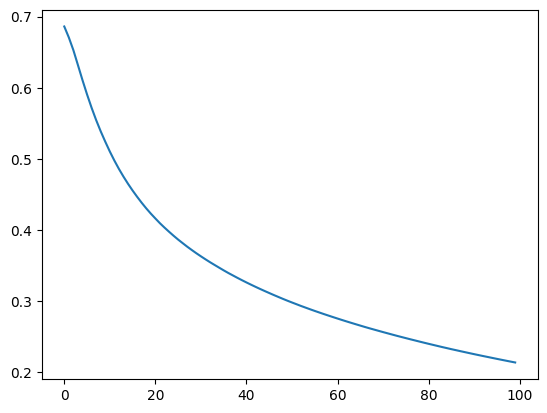

In [ ]:
plt.plot(m_g_losses)

In [ ]:
m_g_model.save_weights('./save_weights/m_g_model_weights.h5')

FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = './save_weights/m_g_model_weights.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

### User Movie Embedding

In [ ]:
MAX_EPOCH = 150
INIT_USER_BATCH_SIZE = 64
FINAL_USER_BATCH_SIZE = 1024

In [ ]:
u_m_model = UserMovieEmbedding(LEN_USERS, EMBEDDING_SIZE)

In [ ]:
u_m_model([np.zeros((1)),np.zeros((1,100))])
u_m_model.summary()

Model: "user_movie_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 2)]               0         
                                                                 
 user_embedding (Embedding)  multiple                  604100    
                                                                 
 movie_user_dot (Dot)        multiple                  0         
                                                                 
 dense_5 (Dense)             multiple                  2         
                                                                 
Total params: 604102 (2.30 MB)
Trainable params: 604102 (2.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss
bce = tf.keras.losses.BinaryCrossentropy()

In [ ]:
u_m_train_loss = tf.keras.metrics.Mean(name='train_loss')
u_m_train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')


@tf.function
def u_m_train_step(u_m_inputs, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = u_m_model(u_m_inputs, training=True)
        loss = bce(labels, predictions)
    gradients = tape.gradient(loss, u_m_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, u_m_model.trainable_variables))

    u_m_train_loss(loss)
    u_m_train_accuracy(labels, predictions)

In [ ]:
# for log
u_m_losses = []

for epoch in range(MAX_EPOCH):

    batch_size = INIT_USER_BATCH_SIZE * (epoch+1)
    if batch_size > FINAL_USER_BATCH_SIZE:
        batch_size = FINAL_USER_BATCH_SIZE
    u_m_generator = generate_user_movie_batch(u_m_pairs, batch_size)

    for step in range(len(user_movie_rating_df)//batch_size):
        # embedding layer update
        u_batch, m_batch, u_m_label_batch = next(u_m_generator)
        m_batch = m_g_model.get_layer('movie_embedding')(m_batch)
        u_m_train_step([u_batch, m_batch], u_m_label_batch)

        print(f'{epoch} epoch, Batch size : {batch_size}, {step} steps, Loss: {u_m_train_loss.result():0.4f}, Accuracy: {u_m_train_accuracy.result() * 100:0.1f}', end='\r')

    u_m_losses.append(u_m_train_loss.result())

KeyboardInterrupt: 

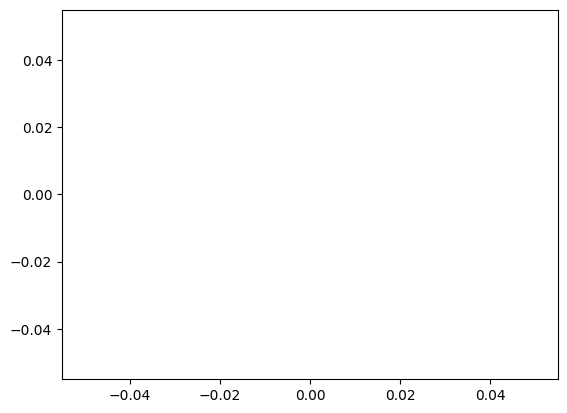

In [ ]:
plt.plot(u_m_losses)

In [ ]:
u_m_model.save_weights('./save_weights/u_m_model_weights.h5')

### visualization

In [ ]:

# model.load_weights('./save_weights/embedding_24epoch.h5')

In [ ]:
# to make embedded movie dataframe
embedded_movie = movies_genres_df['MovieID'].apply(m_g_model.get_layer('movie_embedding'))
columns = [x for x in range(100)]
embedded_movie_df = pd.DataFrame(columns = columns)
for data in embedded_movie:
    embedded_movie_df = embedded_movie_df.append(pd.Series(data), ignore_index=True)
embedded_movie_df.head()

In [ ]:
# Dimension reduction using PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

movie_scaled = StandardScaler().fit_transform(embedded_movie_df)
pca = PCA(n_components=2)
pca.fit(movie_scaled)
movie_pca = pca.transform(movie_scaled)
pca_columns=[f'{n}' for n in range(2)]
movie_df_pca = pd.DataFrame(movie_pca,columns=pca_columns)
movie_df_pca = pd.concat([movie_df_pca, movies_df["Title"]], axis=1)
movie_df_pca = pd.concat([movie_df_pca, movies_df["Genres"]], axis=1)
movie_df_pca.head()

In [ ]:
# visualization
fig = px.scatter(movie_df_pca, x='0', y='1', color='Genres')
fig.show()

In [ ]:
# Dimension reduction using T-SNE
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(embedded_movie_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, movies_df["Title"]], axis=1)
tsne_df = pd.concat([tsne_df, movies_df["Genres"]], axis=1)
tsne_df.head()

In [ ]:
# visualization
fig = px.scatter(tsne_df, x='x', y='y', color='Genres')
fig.show()

In [ ]:
# to make embedded user dataframe
embedded_user = users_df['UserID'].apply(np.int32).apply(u_m_model.get_layer('user_embedding'))
columns = [x for x in range(100)]
embedded_user_df = pd.DataFrame(columns = columns)
for data in embedded_user:
    embedded_user_df = embedded_user_df.append(pd.Series(data.numpy()), ignore_index=True)
embedded_user_df.head()

In [ ]:
users_df.head()

In [ ]:
# Dimension reduction using PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

user_scaled = StandardScaler().fit_transform(embedded_user_df)
pca = PCA(n_components=2)
pca.fit(user_scaled)
user_pca = pca.transform(user_scaled)
pca_columns=[f'{n}' for n in range(2)]
user_df_pca = pd.DataFrame(user_pca,columns=pca_columns)
user_df_pca = pd.concat([user_df_pca, users_df["Gender"]], axis=1)
user_df_pca = pd.concat([user_df_pca, users_df["Age"]], axis=1)
user_df_pca = pd.concat([user_df_pca, users_df["Zip-code"]], axis=1)
user_df_pca.head()

In [ ]:
# visualization
fig = px.scatter(user_df_pca, x='0', y='1', hover_data=user_df_pca)
fig.show()

In [ ]:
# Dimension reduction using T-SNE
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(embedded_user_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, users_df["Gender"]], axis=1)
tsne_df = pd.concat([tsne_df, users_df["Age"]], axis=1)
tsne_df = pd.concat([tsne_df, users_df["Zip-code"]], axis=1)
tsne_df.head()

In [ ]:
# Visualisation
fig = px.scatter(tsne_df, x='x', y='y', hover_data=tsne_df)
fig.show()